# AAE 451 Preliminary Sizing

In [43]:
from typing import Callable

import numpy as np
import pandas as pd
import scipy.constants as consts
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import patheffects, patches

from IPython.display import display_latex

%matplotlib widget

In [44]:
# Define constants
RHO = 1.225  # kg / m^3

# Define requirements
v_to = 8. * consts.knot
r_turn = 200 * consts.foot
climb_rate = 400 * consts.foot / consts.minute
altitude = 200 * consts.foot

lap_straight = 600 * consts.foot
num_laps = 3
max_GTOM = 15 * consts.lb
max_wingspan = 5 * consts.foot

max_length = 60 * consts.inch

Takeoff sizing is... tricky. Our takeoff is going to have to involve a bit of a loft followed by acceleration to stall speed, because our takeoff speed would require insanely low wing loading to stall at that speed.

Let's start by estimating what a realistic stall speed would be as a function of aspect ratio. Assuming SLUF (steady, level, unaccelerating flight), $L=W=mg$, where $L$ is lift, $W$ is weight, $m$ is mass, and $g$ is standard gravitational acceleration. Using the lift coefficient equation, $L=C_L q S$ where the dynamic pressure $q \equiv \frac{1}{2}\rho u^2$, $C_L$ is the aircraft lift coefficient, $S$ is the wing area, $\rho$ is the air density, and $u$ is the flight speed. Aspect ratio is defined as $AR \equiv b^2 / S$, where $b$  is the wingspan. Solving for flight speed in $mg = C_L \frac{1}{2}\rho u^2 S$, we get $u = \sqrt{2mg/C_L S}$, or $u = \sqrt{2mg \cdot AR /C_L b^2}$. If we assume that $C_L = C_{L\text{,max}}$ in our stall constraint condition, we can find $u_\text{stall}$.

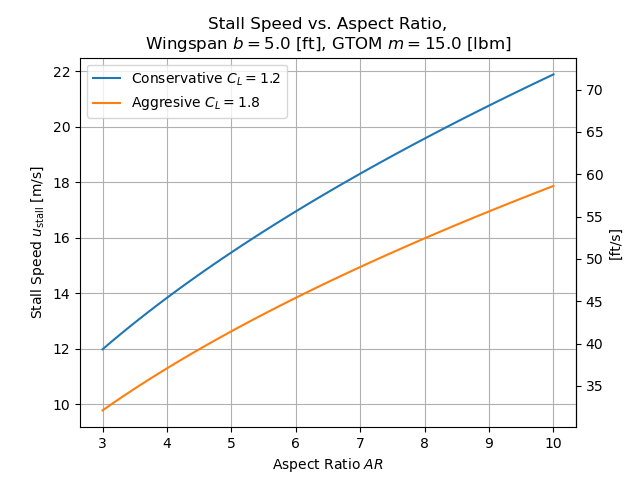

In [58]:
# Define conservative and aggressive values for CL_max
CL_max_cons = 1.2
CL_max_aggr = 1.8

# Define minimum and maximum values for aspect ratio
AR_min = 3
AR_max = 10

AR = np.linspace(AR_min, AR_max)

def calc_stall_speed(m, AR, b, CL_max):
    return np.sqrt(2. * m * consts.g * AR / (CL_max * b**2))

v_stall_cons = calc_stall_speed(max_GTOM, AR, max_wingspan, CL_max_cons)
v_stall_aggr = calc_stall_speed(max_GTOM, AR, max_wingspan, CL_max_aggr)

fig, ax = plt.subplots(1,1)

ax.plot(AR, v_stall_cons, label=f"Conservative $C_L = {CL_max_cons}$")
ax.plot(AR, v_stall_aggr, label=f"Aggresive $C_L = {CL_max_aggr}$")

ax.set_xlabel("Aspect Ratio $AR$")
ax.set_ylabel("Stall Speed $u_\\text{stall}$ [m/s]")

m2ft = lambda x: x / consts.foot
ft2m = lambda x: x * consts.foot

secax = ax.secondary_yaxis('right', functions=(m2ft, ft2m))

secax.set_ylabel('[ft/s]')

ax.set_title(f"Stall Speed vs. Aspect Ratio,\nWingspan $b = {max_wingspan / consts.foot}$ [ft], GTOM $m = {max_GTOM / consts.lb}$ [lbm]")

ax.legend()
ax.grid()
fig.savefig("stall_speed.png", dpi=300)

For a sanity check, plot the wing loading versus aspect ratio. Wing loading is $W/S = W \cdot AR / b^2$.

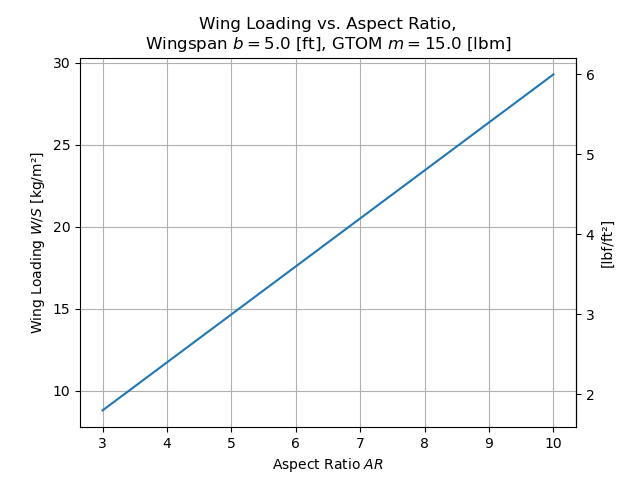

In [46]:
fig, ax = plt.subplots(1,1)

W_S = max_GTOM * AR / max_wingspan**2

ax.plot(AR, W_S)

ax.set_xlabel("Aspect Ratio $AR$")
ax.set_ylabel("Wing Loading $W/S$ [kg/m²]")

kg_m2_2_lbf_ft2 = lambda x: x / (consts.lb / consts.foot**2)
lbf_ft2_2_kg_m2 = lambda x: x * (consts.lb / consts.foot**2)

secax = ax.secondary_yaxis('right', functions=(kg_m2_2_lbf_ft2, lbf_ft2_2_kg_m2))

secax.set_ylabel('[lbf/ft²]')

ax.set_title(f"Wing Loading vs. Aspect Ratio,\nWingspan $b = {max_wingspan / consts.foot}$ [ft], GTOM $m = {max_GTOM / consts.lb}$ [lbm]")

ax.grid()
fig.savefig("wing_loading.png", dpi=300)

We now need to pick a reasonable value from this plot based on realistic aspect ratios and stall speeds. A realistic aspect ratio is probably in the range of 4 on the low end, up to 8 on the high end. These would correspond with mean geometric chords for the wings calculated as follows:

In [47]:
AR_lo = 4
AR_hi = 8

mgc_lo_AR = max_wingspan / AR_lo
mgc_hi_AR = max_wingspan / AR_hi

print(f"Mean Geom. Chord (Low AR)  = {mgc_lo_AR:.2f} m ; {mgc_lo_AR / consts.foot:.2f} ft ; {mgc_lo_AR / consts.inch:.2f} in")
print(f"Mean Geom. Chord (High AR) = {mgc_hi_AR:.2f} m ; {mgc_hi_AR / consts.foot:.2f} ft ; {mgc_hi_AR / consts.inch:.2f} in")

Mean Geom. Chord (Low AR)  = 0.38 m ; 1.25 ft ; 15.00 in
Mean Geom. Chord (High AR) = 0.19 m ; 0.62 ft ; 7.50 in


We can add an "eye test" to visualize what these look like.

/tmp/ipykernel_3313056/315812833.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


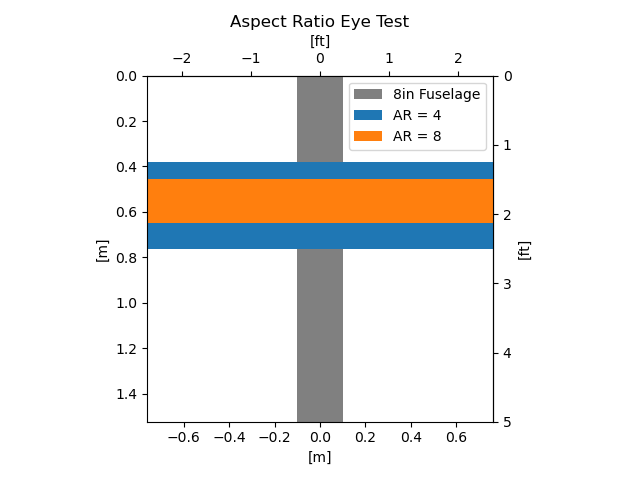

In [48]:
fig, ax = plt.subplots(1,1)

ax.set_xlim(-max_wingspan/2, max_wingspan/2)
ax.set_ylim(0, max_length)
ax.set_aspect('equal')
ax.invert_yaxis()

fuselage = patches.Rectangle((-4 * consts.inch, 0), 8 * consts.inch, max_length, facecolor='gray', label="8in Fuselage")
wing_lo_AR = patches.Rectangle((-max_wingspan / 2, max_length * 0.25), max_wingspan, mgc_lo_AR, facecolor='C0', label=f"AR = {AR_lo}")
wing_hi_AR = patches.Rectangle((-max_wingspan / 2, max_length * 0.3), max_wingspan, mgc_hi_AR, facecolor='C1', label=f"AR = {AR_hi}")

ax.add_patch(fuselage)
ax.add_patch(wing_lo_AR)
ax.add_patch(wing_hi_AR)

ax.legend(handles=[fuselage, wing_lo_AR, wing_hi_AR])

secaxx = ax.secondary_xaxis('top', functions=(m2ft, ft2m))
secaxy = ax.secondary_yaxis('right', functions=(m2ft, ft2m))

ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
secaxx.set_xlabel('[ft]')
secaxy.set_ylabel('[ft]')

ax.set_title("Aspect Ratio Eye Test")
fig.tight_layout()
fig.savefig("eye_test.png", dpi=300)

Whatever we pick for aspect ratio or stall speed, we will need a propultion system that can accelerate the vehicle to that speed from the launch speed before it hits the ground. We can solve this as a relatively simple dynamics problem.

Initially, we're going to assume the vehicle is launched at some initial flightpath angle at the launch speed, so it has some inital vertical and horiziontal velocity components. It will start from a certain vertical height, and begin falling due to gravity. Let's assume a starting height and a minimum acceptable height so we don't impact the ground. During this time, the vehicle accelerates under thrust from the launch speed. As the vehicle accelerates, it generates increasing lift proportional to its airspeed squared according to the lift equation. Simultaneously, drag increases on the vehicle as lift and velocity increase. A free body diagram describing the problem is shown below:

<!-- ![Takeoff Dynamics](takeoff_dynamics.png) -->

The dynamical equations are as follows:

$$\begin{align*}
\dot{u} &= \frac{T}{m}\cos\left(\alpha_{C_L\text{max}} + \phi\right) - \frac{L}{m}\sin\phi - \frac{D}{m}\cos\phi\\
\dot{w} &= g - \frac{T}{m}\sin\left(\alpha_{C_L\text{max}} + \phi\right) - \frac{L}{m}\cos\phi + \frac{D}{m}\sin\phi\\
u(0) &= V_{TO} \cos \phi_0\\
w(0) &= -V_{TO} \sin \phi_0
\end{align*}$$

Where $u$ is horizontal velocity, $w$ is vertical velocity (positive down), $g$ is gravitational acceleration, $m$ is mass, $L$ is lift, $D$ is drag, $T$ is thrust, $V_{TO}$ is the launch velocity, $\phi$ is the flightpath angle (satisfying $\tan\phi = -w/u$), and $\alpha_{C_L\text{max}}$ is the angle of attack at stall. This value $\alpha_{C_L\text{max}}$ may be estimated using the relation $C_L = C_{L0} + C_{L\alpha}\alpha$, where $C_{L0}$ depends on flap deployment (and is zero with no flaps deployed), and $C_{L\alpha} = 2\pi$ for a theoretical infinite airfoil, but 3D effects reduce this value; for a finite elliptical wing, $C_{L\alpha} = \frac{2\pi}{1+2/AR}$. Lift is found using the lift equation and the stall lift coefficient: $L = \frac{1}{2}\rho V^2 \frac{b^2}{AR} C_{L\text{,max}}$, where $V=\sqrt{u^2 + w^2}$. Similarly, drag $D = \frac{1}{2}\rho V^2 \frac{b^2}{AR} C_{D}$. The drag coefficient is $C_D = C_{D0} + \frac{C_{L\text{,max}}^2}{\pi AR e}$, where $e$ is the Oswald efficiency factor.

These equations could potentially be simplified to solve for some friendly relation, preferably in terms of wing and power loading for compatibility with other constraints. However, since computational power is so cheap, we can solve these equations numerically to simulate the launch dynamics over a design space of aspect ratio and thrust-to-weight ratio $TWR \equiv T/mg$.

In [49]:
# Initial conditions
STARTING_ALT = 2.0 # meters
MIN_STALL_ALT = 1.0 # meters

INIT_FLIGHTPATH_ANGLE = np.deg2rad(15)
y0 = np.array([0.0, -STARTING_ALT, np.cos(INIT_FLIGHTPATH_ANGLE) * v_to, -np.sin(INIT_FLIGHTPATH_ANGLE) * v_to])

# Conservative and Aggressive values for assumed values
CD0_cons = 0.05
CD0_aggr = 0.025
e_factor_cons = 0.70
e_factor_aggr = 0.85

# Potentially unreasonable bounds on TWR
TWR_lo = 0.5
TWR_hi = 1.1
TWR = np.linspace(TWR_lo, TWR_hi)

CL0_FLAPS = 0

# ODE system
def odefunc(t, y, AR, TWR, m, b, CL_max, CL0, CD0, e_factor):
    x, z, u, w = y
    
    V = np.sqrt(u**2 + w**2)
    phi = np.atan2(-w, u)
    
    CL_alpha = 2*np.pi / (1 + 2 / AR)
    alpha_CLmax = (CL_max - CL0) / CL_alpha
    CD = CD0 + CL_max**2 / (np.pi * AR * e_factor)
    
    T_m = TWR * consts.g
    
    q = 0.5 * RHO * V**2
    S = b**2 / AR
    L_m = q * S * CL_max / m
    D_m = q * S * CD / m
    
    du_dt = T_m * np.cos(alpha_CLmax + phi) - L_m * np.sin(phi) - D_m * np.cos(phi) 
    dw_dt = consts.g - T_m * np.sin(alpha_CLmax + phi) - L_m * np.cos(phi) + D_m * np.sin(phi)
    
    dy_dt = np.array([u, w, du_dt, dw_dt])
    return dy_dt

In [50]:
# ODE solver arguments
t_span = (0., 10.)

# When critical altitude is crossed
def event_threshold(t, y, AR, TWR, m, b, CL_max, CL0, CD0, e_factor):
    return y[1] + MIN_STALL_ALT
event_threshold.direction = 1. # Only trigger on increasing (altitude down)

# When aircraft begins climbing
def event_success(t, y, AR, TWR, m, b, CL_max, CL0, CD0, e_factor):
    return y[3]
event_success.terminal = True
event_success.direction = -1. # Only trigger on decreasing (negative = up)

# When aircraft altitude equals zero
def event_crash(t, y, AR, TWR, m, b, CL_max, CL0, CD0, e_factor):
    return y[1]
event_crash.terminal = True

# When aircraft flight path exceeds initial flightpath angle
def event_loop(t, y, AR, TWR, m, b, CL_max, CL0, CD0, e_factor):
    return np.atan2(-y[3], y[2]) - INIT_FLIGHTPATH_ANGLE
event_loop.terminal = True
event_loop.direction = +1. # Only trigger on increasing

events = [event_threshold, event_success, event_crash, event_loop]

args = (5, 0.95, max_GTOM, max_wingspan, CL_max_cons, CL0_FLAPS, CD0_cons, e_factor_cons)
sol = solve_ivp(odefunc, t_span, y0, events=events, args=args, rtol=1e-10, atol=1e-10)

sol

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 0.000e+00  2.941e-03 ...  1.153e+00  1.156e+00]
        y: [[ 0.000e+00  1.172e-02 ...  1.062e+01  1.067e+01]
            [-2.000e+00 -2.003e+00 ... -9.812e-03  3.469e-17]
            [ 3.975e+00  3.998e+00 ...  1.489e+01  1.492e+01]
            [-1.065e+00 -1.052e+00 ...  3.110e+00  3.102e+00]]
      sol: None
 t_events: [array([ 8.469e-01]), array([], dtype=float64), array([ 1.156e+00]), array([], dtype=float64)]
 y_events: [array([[ 6.538e+00, -1.000e+00,  1.178e+01,  3.115e+00]]), array([], dtype=float64), array([[ 1.067e+01,  3.469e-17,  1.492e+01,  3.102e+00]]), array([], dtype=float64)]
     nfev: 254
     njev: 0
      nlu: 0

In [51]:
# Solve ODE over design space
ARx, TWRy = np.meshgrid(AR, TWR)

sols = np.empty_like(ARx, dtype=object)
u_reached = np.full_like(ARx, np.nan)
min_alt = np.full_like(ARx, np.nan)

for (idx, ARi), (_, TWRj) in zip(np.ndenumerate(ARx), np.ndenumerate(TWRy)):
    args = (ARi, TWRj, max_GTOM, max_wingspan, CL_max_cons, CL0_FLAPS, CD0_cons, e_factor_cons)
    sol = solve_ivp(odefunc, t_span, y0, events=events, args=args, rtol=1e-10, atol=1e-10)
    
    sols[idx] = sol
    if len(sol.t_events[0]):
        u_reached[idx] = sol.y_events[0][0,2]
    elif len(sol.t_events[1]):
        u_reached[idx] = sol.y_events[1][0,2]
    elif len(sol.t_events[3]):
        u_reached[idx] = sol.y_events[3][0,2]
        
    if len(sol.t_events[1]):
        min_alt[idx] = -sol.y_events[1][0,1]
    elif len(sol.t_events[2]):
        min_alt[idx] = 0.
    elif len(sol.t_events[3]):
        min_alt[idx] = -sol.y_events[3][0,1]


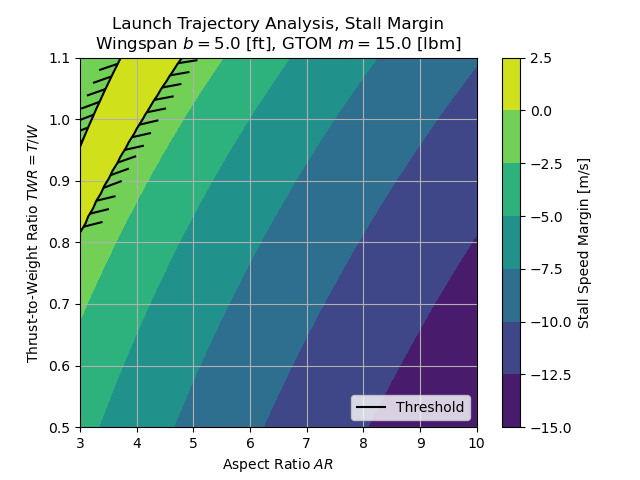

In [52]:
fig, ax = plt.subplots(1,1)

V_stall = calc_stall_speed(max_GTOM, ARx, max_wingspan, CL_max_cons)

cm = ax.contourf(ARx, TWRy, u_reached - V_stall)
threshhold = ax.contour(ARx, TWRy, u_reached - V_stall, [0], colors='k')
threshhold.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cb = fig.colorbar(cm, ax=ax)

ax.set_xlabel("Aspect Ratio $AR$")
ax.set_ylabel("Thrust-to-Weight Ratio $TWR = T/W$")
cb.ax.set_ylabel("Stall Speed Margin [m/s]")
legend_lines = [
    plt.Line2D([], [], color='k', label="Threshold"),
]
ax.legend(handles=legend_lines, loc="lower right")
ax.set_title(f"Launch Trajectory Analysis, Stall Margin\nWingspan $b = {max_wingspan / consts.foot}$ [ft], GTOM $m = {max_GTOM / consts.lb}$ [lbm]")
ax.grid()
fig.savefig("stall_margin.png", dpi=300)

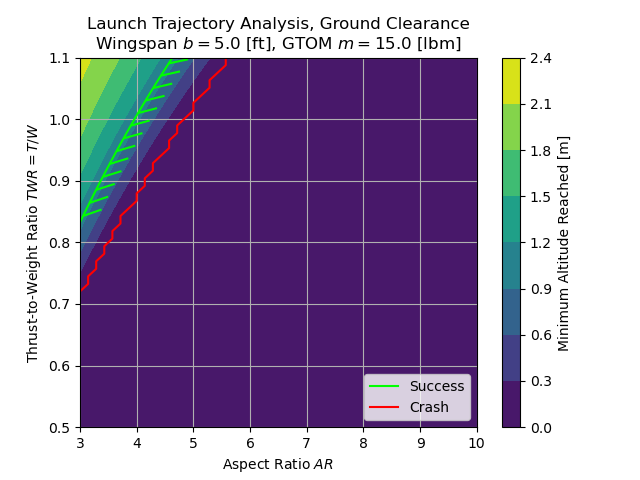

In [57]:
fig, ax = plt.subplots(1,1)

cm = ax.contourf(ARx, TWRy, min_alt)
ax.contour(ARx, TWRy, min_alt, [0], colors='r')
success = ax.contour(ARx, TWRy, min_alt, [MIN_STALL_ALT], colors='lime')
success.set(path_effects=[patheffects.withTickedStroke(angle=-45)])
cb = fig.colorbar(cm, ax=ax)

ax.set_xlabel("Aspect Ratio $AR$")
ax.set_ylabel("Thrust-to-Weight Ratio $TWR = T/W$")
cb.ax.set_ylabel("Minimum Altitude Reached [m]")
legend_lines = [
    plt.Line2D([], [], color='lime', label="Success"),
    plt.Line2D([], [], color='r', label="Crash"),
]
ax.legend(handles=legend_lines, loc="lower right")
ax.set_title(f"Launch Trajectory Analysis, Ground Clearance\nWingspan $b = {max_wingspan / consts.foot}$ [ft], GTOM $m = {max_GTOM / consts.lb}$ [lbm]")
ax.grid()
fig.savefig("ground_clearance.png", dpi=300)

In [54]:
TWRy[:,0], ARx[0,:]

(array([0.5       , 0.5122449 , 0.5244898 , 0.53673469, 0.54897959,
        0.56122449, 0.57346939, 0.58571429, 0.59795918, 0.61020408,
        0.62244898, 0.63469388, 0.64693878, 0.65918367, 0.67142857,
        0.68367347, 0.69591837, 0.70816327, 0.72040816, 0.73265306,
        0.74489796, 0.75714286, 0.76938776, 0.78163265, 0.79387755,
        0.80612245, 0.81836735, 0.83061224, 0.84285714, 0.85510204,
        0.86734694, 0.87959184, 0.89183673, 0.90408163, 0.91632653,
        0.92857143, 0.94081633, 0.95306122, 0.96530612, 0.97755102,
        0.98979592, 1.00204082, 1.01428571, 1.02653061, 1.03877551,
        1.05102041, 1.06326531, 1.0755102 , 1.0877551 , 1.1       ]),
 array([ 3.        ,  3.14285714,  3.28571429,  3.42857143,  3.57142857,
         3.71428571,  3.85714286,  4.        ,  4.14285714,  4.28571429,
         4.42857143,  4.57142857,  4.71428571,  4.85714286,  5.        ,
         5.14285714,  5.28571429,  5.42857143,  5.57142857,  5.71428571,
         5.85714286,  6.  

np.float64(1.1)

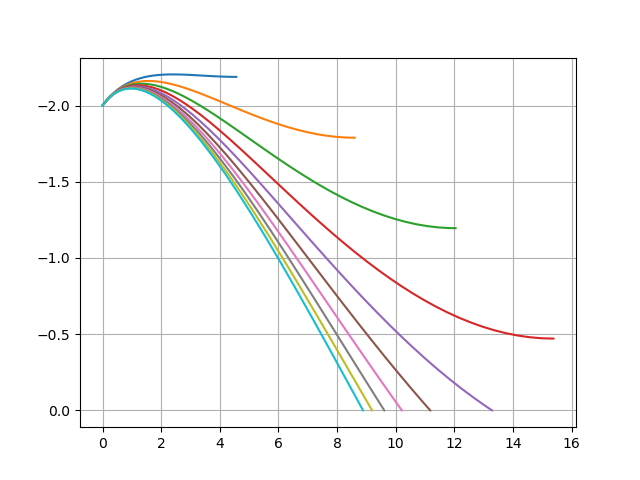

In [55]:
fig, ax = plt.subplots(1,1)
ax.invert_yaxis()

for i in range(0, 50, 5):
    sol = sols[49, i]
    ax.plot(sol.y[0], sol.y[1])
ax.grid()

TWR[49]

In [56]:
# args = (6, 0.9, max_GTOM, max_wingspan, CL_max_cons, CL0_FLAPS, CD0_cons, e_factor_cons)
# sol = solve_ivp(odefunc, t_span, y0, events=events, args=args, rtol=1e-10, atol=1e-10)

# sol

# t = sol.t
# x, z, u, w = sol.y
# AR, TWR, m, b, CL_max, CL0, CD0, e_factor = args

# V = np.sqrt(u**2 + w**2)
# phi = np.atan2(-w, u)

# CL_alpha = 2*np.pi / (1 + 2 / AR)
# alpha_CLmax = (CL_max - CL0) / CL_alpha
# CD = CD0 + CL_max**2 / (np.pi * AR * e_factor)

# T_m = TWR * consts.g

# q = 0.5 * RHO * u**2
# S = b**2 / AR
# L_m = q * S * CL_max / m
# D_m = q * S * CD / m

# fig, (ax, ax2, ax3) = plt.subplots(3,1, figsize=(16, 8))
# # ax2 = ax.twinx()
# ax.plot(x, z)
# ax.invert_yaxis()
# ax.set_aspect('equal')
# ax2.plot(u, w)
# ax2.invert_yaxis()
# ax2.set_aspect('equal')
# print(f"{CL_alpha = }")
# print(f"{np.rad2deg(alpha_CLmax) = }")
# print(f"{CD = }")
# print(f"{T_m = }")
# ax4 = ax3.twinx()
# # ax3.plot(t, V)
# ax4.plot(t, phi)
# # ax4.plot(t, L_m)
# # ax4.plot(t, D_m)
# fig.tight_layout()
# sol